In [1]:
from torchvision import transforms
from torchvision import models
from PIL import Image

import matplotlib.pyplot as plt

import torch.nn.functional as F 
import torch.optim as optim
import torch.nn as nn
import torch

device = torch.device("mps")
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <44B645FB-F027-3EE5-86D7-DBF8E2FC6264> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/bahk

In [2]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target

    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return input

In [3]:
def gram_matrix(x):
    a, b, c, d = x.size()
    features = x.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [4]:
class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_features).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std  = std.view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

In [5]:
def getStyleModelAndLosses(cnn, styleImg, contentImg):
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    normalization_mean = torch.tensor([0.485, 0.224, 0.225]).to(device)
    normalization_std  = torch.tensor([0.229, 0.224, 0.225]).to(device)
    normalization      = Normalization(normalization_mean, normalization_std).to(device)
    contentLoss, styleLoss = [], []
    
    model = nn.Sequential(normalization)
    layerIndex = 0

    for layer in cnn.children():
        # Check the layer is available 
        if isinstance(layer, nn.Conv2d):
            layerIndex += 1
            name = 'conv_{}'.format(layerIndex)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(layerIndex)
            layer = nn.ReLU(inplace=False)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'maxpool_{}'.format(layerIndex)
        
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(layerIndex)
        
        # Excpetion case
        else:
            raise RuntimeError('Unreconginzed layer : {}'.format(layer.__class__.__name__))
    
        model.add_module(name, layer)
        if name in content_layers:
            target = model(contentImg)
            contentLossItem = ContentLoss(target)
            model.add_module("content_loss_{}".format(layerIndex), contentLossItem)
            contentLoss.append(contentLossItem)

        if name in style_layers:
            targetFeature = model(styleImg)
            styleLossItem = StyleLoss(targetFeature)
            model.add_module("style_loss_{}".format(layerIndex), styleLossItem)
            styleLoss.append(styleLossItem)

        for i in range(len(model) -1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break
        
        model = model[:(i + 1)]
        return model, styleLoss, contentLoss


In [6]:
def runStyleTransfer(cnn, contentImg, styleImg, num_steps=300, style_weight=100000, content_weight=1):
    inputImg = contentImg.clone().detach().requires_grad_(True)
    model, styleLosses, contentLosses = getStyleModelAndLosses(cnn, styleImg, contentImg)
    optimizer = optim.LBFGS([inputImg])
    iteration = [0]
    
    while iteration[0] <= num_steps:
        def closuer():
            inputImg.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(inputImg)
            
            styleScore = 0
            contentScore = 0
            for sl in styleLosses:
                styleScore += sl.loss
            
            for cl in contentLosses:
                contentScore += cl.loss
            
            loss = (style_weight * styleScore) + (content_weight * contentScore)
            loss.backward()
            
            iteration[0] += 1
            if iteration[0] % 50 == 0:
                print('Iteration {}: Style Loss {:4f}\tContent Loss : {:4f}'.format(
                    iteration[0], styleScore.item(), contentScore
                ))
        
            return styleScore + contentScore
        optimizer.step(closuer)
    return inputImg.data.clamp_(0, 1)

In [7]:
def imageLoader(image_path):
    loader = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    image = Image.open(image_path).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device)

def imshow(image, title):
    unloader = transforms.ToPILImage()
    image = unloader(image.squeeze(0).cpu())
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

styleImg = imageLoader("../data/imgA.jpeg")
contentImg = imageLoader("../data/imgB.jpeg")

In [8]:
output = runStyleTransfer(cnn, contentImg=contentImg, styleImg=styleImg, num_steps=10000)

Iteration 50: Style Loss 0.000000	Content Loss : 0.000000
Iteration 100: Style Loss 0.000000	Content Loss : 0.000000
Iteration 150: Style Loss 0.000000	Content Loss : 0.000000
Iteration 200: Style Loss 0.000000	Content Loss : 0.000000
Iteration 250: Style Loss 0.000000	Content Loss : 0.000000
Iteration 300: Style Loss 0.000000	Content Loss : 0.000000
Iteration 350: Style Loss 0.000000	Content Loss : 0.000000
Iteration 400: Style Loss 0.000000	Content Loss : 0.000000
Iteration 450: Style Loss 0.000000	Content Loss : 0.000000
Iteration 500: Style Loss 0.000000	Content Loss : 0.000000
Iteration 550: Style Loss 0.000000	Content Loss : 0.000000
Iteration 600: Style Loss 0.000000	Content Loss : 0.000000
Iteration 650: Style Loss 0.000000	Content Loss : 0.000000
Iteration 700: Style Loss 0.000000	Content Loss : 0.000000
Iteration 750: Style Loss 0.000000	Content Loss : 0.000000
Iteration 800: Style Loss 0.000000	Content Loss : 0.000000
Iteration 850: Style Loss 0.000000	Content Loss : 0.00000

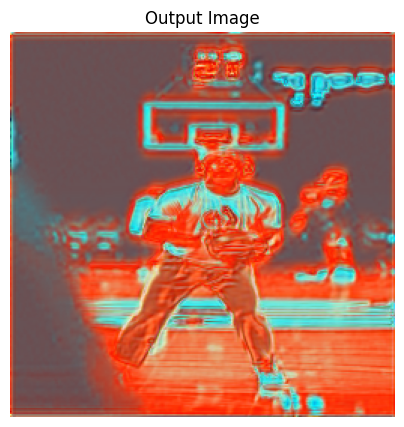

In [9]:
imshow(output, title="Output Image")